Future ideas:

Different categorical imputation techniques: One Hot, Target Encode, Entity Embedding, One Hot collapse small levels

Feature importance

Remove Redundant categories

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv')
y = data['SalePrice']
X = data.drop(['Id', 'SalePrice'], axis=1)

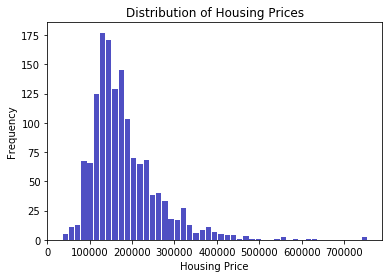

In [3]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Housing Price')
plt.ylabel('Frequency')
plt.title('Distribution of Housing Prices')
plt.show()

In [312]:
X.shape

(1460, 79)

## High Correlations
* YearBuilt x GarageYrBlt
* GrLivArea x TotRmsAbvGrd
* 1stFlrSF x TotalBsmt
* GarageCars X GarageArea

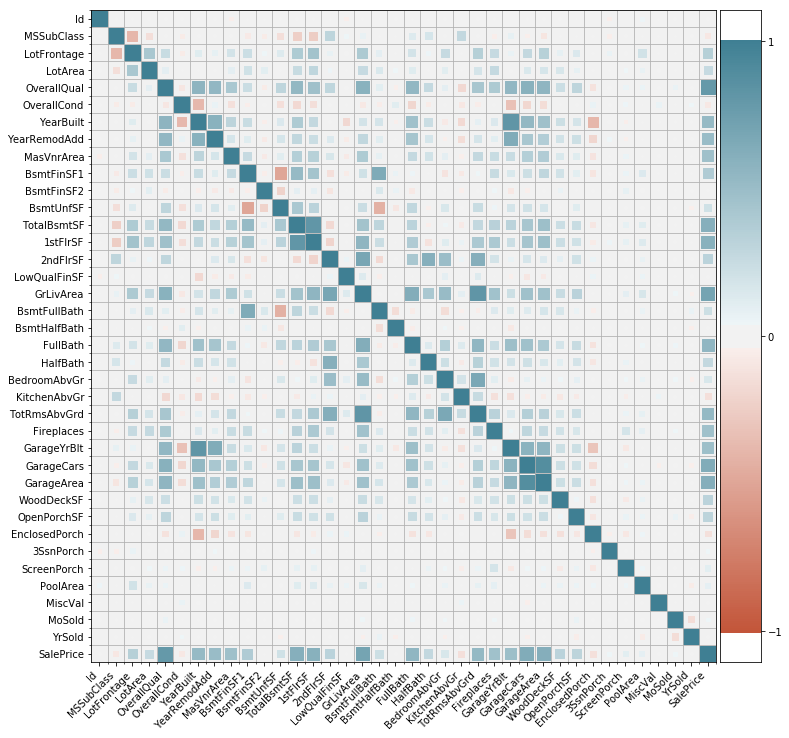

In [461]:
from heatmap import corrplot
plt.figure(figsize=(12, 12))
corrplot(data.corr(), size_scale=250, marker='s')

## Feature Engineering

Ideas - total number of bathrooms, total square feet, indicator for new, age instead of yr built

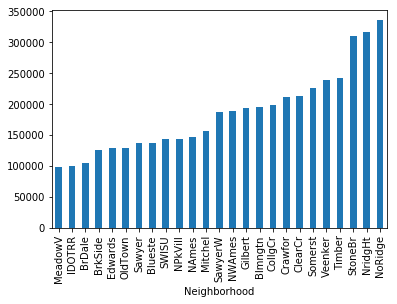

In [19]:
data.groupby(['Neighborhood'])['SalePrice'].mean().sort_values().plot.bar()

In [7]:
def neighborhood_level(df):
    if df['Neighborhood'] in ('StoneBr', 'NridgHt', 'NoRidge'):
        return 'Upper'
    elif df['Neighborhood'] in ('Timber', 'Veenker', 'Somerst', 'ClearCr',
                               'Crawfor', 'CollgCr', 'Blmngtn', 'Gilbert',
                               'NWAmes', 'SawyerW'):
        return 'Upper Middle'
    elif df['Neighborhood'] in ('Mitchel', 'NWAmes', 'NPkVill', 'SWISU',
                               'Sawyer', 'OldTown', 'Edwards', 'BrkSide',
                               'NAmes'):
        return 'Lower Middle'
    elif df['Neighborhood'] in ('BrDale', 'IDOTRR', 'MeadowV'):
        return 'Lower'
    
X['NeighborhoodLevel'] = X.apply(neighborhood_level, axis=1)

In [2]:
X['TotalBath'] = X['BsmtFullBath'] + X['BsmtHalfBath'] + \
                    X['FullBath'] + X['HalfBath']
    
X['TotalSqFeet'] = X['GrLivArea'] + X['TotalBsmtSF']

X['NewHouse'] = np.where(X['YearBuilt'] == X['YearRemodAdd'], 1, 0)

In [465]:
Garage = X[['GarageType', 'GarageYrBlt', 'GarageFinish',
           'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA
5,Attchd,1993.0,Unf,2,480,TA,TA
6,Attchd,2004.0,RFn,2,636,TA,TA
7,Attchd,1973.0,RFn,2,484,TA,TA
8,Detchd,1931.0,Unf,2,468,Fa,TA
9,Attchd,1939.0,RFn,1,205,Gd,TA


## Missing Values

In [324]:
X.isnull().sum()[X.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [3]:
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt']) #group and make categorical

## Categorical

In [344]:
X.select_dtypes(exclude=['object']).nunique()
# Convert 'MSSubClass', 'OverallQual', 'OverallCond' to categorical

MSSubClass         15
LotFrontage       111
LotArea          1073
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageYrBlt       102
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

test_size = .3
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = list(X.select_dtypes(exclude=['object']).columns)
numeric_features = [e for e in numeric_features if e 
                    not in ('MSSubClass', 'OverallQual', 'OverallCond')]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_features = list(X.select_dtypes(include=['object']).columns)
categorical_features.extend(['MSSubClass', 'OverallQual', 'OverallCond'])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

## Grid Search and CV

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error, r2_score
import xgboost as xgb

#xgboost = xgb.XGBRegressor(max_depth=4,
#                           colsample_bytree=0.6,
#                           subsample=0.8,
#                           reg_alpha=110,
#                           learning_rate=0.005,
#                           n_estimators=6000,
#                           nthread=4, seed=27)

xgboost = xgb.XGBRegressor(max_depth=3,
                           min_child_weight=0,
                           reg_alpha=1,
                           reg_lambda=1,
                           nthread=4, seed=27)

param_grid1 = {
    "max_depth":range(3,10,2),
    'min_child_weight':range(1,6,2)
}

param_grid2 = {
    "max_depth":[2,3,4],
    'min_child_weight':[0,1,2]
}

param_grid3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_grid4 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}

param_grid5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

param_grid6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

param_grid7 = {
 'reg_lambda':[1e-5, 0.1, 1, 10, 100]
}

param_grid8 = {
    "n_estimators": [1000, 5000, 10000],
    "learning_rate": [0.1, 0.05, 0.01],
}

param_grid9 = {
    "n_estimators": [5000, 50000, 100000],
    "learning_rate": [0.01, 0.001, 0.0001],
}


pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('xgboost', xgboost)])
def rmsle(y, y0):
    return -np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

search = GridSearchCV(xgboost, param_grid8, cv=5,
                      scoring=make_scorer(rmsle))


In [ ]:
search.fit(X_train, y_train)

In [41]:
#rmsle
search.cv_results_['mean_test_score']

array([-0.15393098, -0.15262002, -0.1424845 , -0.14723422, -0.15268276])

In [42]:
search.best_params_

{'reg_lambda': 1}

TypeError: 'GridSearchCV' object is not subscriptable

## Validation

In [451]:
xgboost.fit(preprocessor.fit_transform(X_train), y_train)
validation = xgboost.predict(preprocessor.transform(X_val))
rmsle(validation, np.array(y_val))

-0.14945392317449965

<function matplotlib.pyplot.show(*args, **kw)>

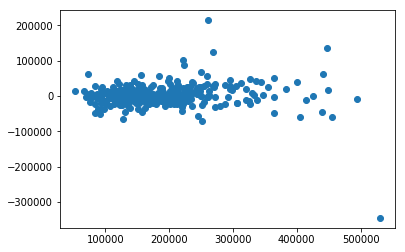

In [458]:
plt.scatter(validation, y_val - validation)
plt.show()

## Fit Full Model

In [455]:
xgboost.fit(preprocessor.fit_transform(X), y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=nan, monotone_constraints='()',
       n_estimators=5000, n_jobs=4, nthread=4, num_parallel_tree=1,
       objective='reg:gamma', random_state=27, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=None, seed=27, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [456]:
test = pd.read_csv('test.csv')
X_test = preprocessor.transform(test)

prediction = xgboost.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':prediction})

submission.to_csv('Predictions/HousingPrices4.csv', index=False)